In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100,
                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
num_epochs = 20

In [6]:
print("--- Training with SGD ---")
net_sgd = Net().to(device)
criterion_sgd = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(net_sgd.parameters(), lr=0.001, momentum=0.9)

log_interval = 100
sgd_train_losses = []
sgd_accuracies_per_class = {c: [] for c in classes}
sgd_train_steps = []
current_step_sgd = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer_sgd.zero_grad()
        outputs = net_sgd(inputs)
        loss = criterion_sgd(outputs, labels)
        loss.backward()
        optimizer_sgd.step()

        running_loss += loss.item()

        if (i + 1) % log_interval == 0:
            sgd_train_losses.append(running_loss / log_interval)
            sgd_train_steps.append(current_step_sgd + log_interval)
            running_loss = 0.0

            with torch.no_grad():
                class_correct = list(0. for i in range(10))
                class_total = list(0. for i in range(10))
                outputs = net_sgd(inputs)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for k in range(labels.size(0)):
                    label_idx = labels[k]
                    class_correct[label_idx] += c[k].item()
                    class_total[label_idx] += 1
                for j in range(10):
                    if class_total[j] > 0:
                        sgd_accuracies_per_class[classes[j]].append(class_correct[j] / class_total[j])
                    else:
                        sgd_accuracies_per_class[classes[j]].append(0.0)
            print(f'SGD Epoch [{epoch + 1}, {i + 1:5d}] loss: {sgd_train_losses[-1]:.3f}')
        current_step_sgd += 1

print('Finished Training with SGD')

--- Training with SGD ---
SGD Epoch [1,   100] loss: 2.301
SGD Epoch [1,   200] loss: 2.297
SGD Epoch [1,   300] loss: 2.293
SGD Epoch [2,   100] loss: 2.274
SGD Epoch [2,   200] loss: 2.252
SGD Epoch [2,   300] loss: 2.200
SGD Epoch [3,   100] loss: 2.101
SGD Epoch [3,   200] loss: 2.060
SGD Epoch [3,   300] loss: 2.014
SGD Epoch [4,   100] loss: 1.962
SGD Epoch [4,   200] loss: 1.946
SGD Epoch [4,   300] loss: 1.921
SGD Epoch [5,   100] loss: 1.876
SGD Epoch [5,   200] loss: 1.849
SGD Epoch [5,   300] loss: 1.846
SGD Epoch [6,   100] loss: 1.766
SGD Epoch [6,   200] loss: 1.751
SGD Epoch [6,   300] loss: 1.727
SGD Epoch [7,   100] loss: 1.684
SGD Epoch [7,   200] loss: 1.663
SGD Epoch [7,   300] loss: 1.655
SGD Epoch [8,   100] loss: 1.623
SGD Epoch [8,   200] loss: 1.607
SGD Epoch [8,   300] loss: 1.595
SGD Epoch [9,   100] loss: 1.580
SGD Epoch [9,   200] loss: 1.551
SGD Epoch [9,   300] loss: 1.564
SGD Epoch [10,   100] loss: 1.538
SGD Epoch [10,   200] loss: 1.525
SGD Epoch [10, 

In [7]:

print("\n--- Training with AdamW ---")
net_adamw = Net().to(device)
criterion_adamw = nn.CrossEntropyLoss()
optimizer_adamw = optim.AdamW(net_adamw.parameters(), lr=0.001)

adamw_train_losses = []
adamw_accuracies_per_class = {c: [] for c in classes}
adamw_train_steps = []
current_step_adamw = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer_adamw.zero_grad()
        outputs = net_adamw(inputs)
        loss = criterion_adamw(outputs, labels)
        loss.backward()
        optimizer_adamw.step()

        running_loss += loss.item()

        if (i + 1) % log_interval == 0:
            adamw_train_losses.append(running_loss / log_interval)
            adamw_train_steps.append(current_step_adamw + log_interval)
            running_loss = 0.0

            with torch.no_grad():
                class_correct = list(0. for i in range(10))
                class_total = list(0. for i in range(10))
                outputs = net_adamw(inputs)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for k in range(labels.size(0)):
                    label_idx = labels[k]
                    class_correct[label_idx] += c[k].item()
                    class_total[label_idx] += 1
                for j in range(10):
                    if class_total[j] > 0:
                        adamw_accuracies_per_class[classes[j]].append(class_correct[j] / class_total[j])
                    else:
                        adamw_accuracies_per_class[classes[j]].append(0.0)
            print(f'AdamW Epoch [{epoch + 1}, {i + 1:5d}] loss: {adamw_train_losses[-1]:.3f}')
        current_step_adamw += 1

print('Finished Training with AdamW')


--- Training with AdamW ---
AdamW Epoch [1,   100] loss: 1.919
AdamW Epoch [1,   200] loss: 1.616
AdamW Epoch [1,   300] loss: 1.466
AdamW Epoch [2,   100] loss: 1.316
AdamW Epoch [2,   200] loss: 1.251
AdamW Epoch [2,   300] loss: 1.219
AdamW Epoch [3,   100] loss: 1.099
AdamW Epoch [3,   200] loss: 1.062
AdamW Epoch [3,   300] loss: 1.031
AdamW Epoch [4,   100] loss: 0.962
AdamW Epoch [4,   200] loss: 0.941
AdamW Epoch [4,   300] loss: 0.922
AdamW Epoch [5,   100] loss: 0.868
AdamW Epoch [5,   200] loss: 0.844
AdamW Epoch [5,   300] loss: 0.829
AdamW Epoch [6,   100] loss: 0.789
AdamW Epoch [6,   200] loss: 0.799
AdamW Epoch [6,   300] loss: 0.768
AdamW Epoch [7,   100] loss: 0.741
AdamW Epoch [7,   200] loss: 0.740
AdamW Epoch [7,   300] loss: 0.730
AdamW Epoch [8,   100] loss: 0.692
AdamW Epoch [8,   200] loss: 0.688
AdamW Epoch [8,   300] loss: 0.702
AdamW Epoch [9,   100] loss: 0.663
AdamW Epoch [9,   200] loss: 0.657
AdamW Epoch [9,   300] loss: 0.654
AdamW Epoch [10,   100] lo

In [8]:

def evaluate_model(net, dataloader, name=""):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total
    print(f'Accuracy of the network trained with {name} on the 10000 test images: {accuracy}%')

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    print(f"\nAccuracy per class on the test set (trained with {name}):")
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print("\n--- Evaluating on Test Data ---")
evaluate_model(net_sgd, testloader, "SGD")
evaluate_model(net_adamw, testloader, "AdamW")


--- Evaluating on Test Data ---
Accuracy of the network trained with SGD on the 10000 test images: 57%

Accuracy per class on the test set (trained with SGD):
Accuracy for class: plane is 75.9 %
Accuracy for class: car   is 59.5 %
Accuracy for class: bird  is 44.8 %
Accuracy for class: cat   is 40.2 %
Accuracy for class: deer  is 49.0 %
Accuracy for class: dog   is 50.3 %
Accuracy for class: frog  is 52.4 %
Accuracy for class: horse is 76.2 %
Accuracy for class: ship  is 59.0 %
Accuracy for class: truck is 63.6 %
Accuracy of the network trained with AdamW on the 10000 test images: 80%

Accuracy per class on the test set (trained with AdamW):
Accuracy for class: plane is 82.2 %
Accuracy for class: car   is 91.9 %
Accuracy for class: bird  is 70.1 %
Accuracy for class: cat   is 66.1 %
Accuracy for class: deer  is 72.9 %
Accuracy for class: dog   is 73.9 %
Accuracy for class: frog  is 89.9 %
Accuracy for class: horse is 87.7 %
Accuracy for class: ship  is 84.1 %
Accuracy for class: truck

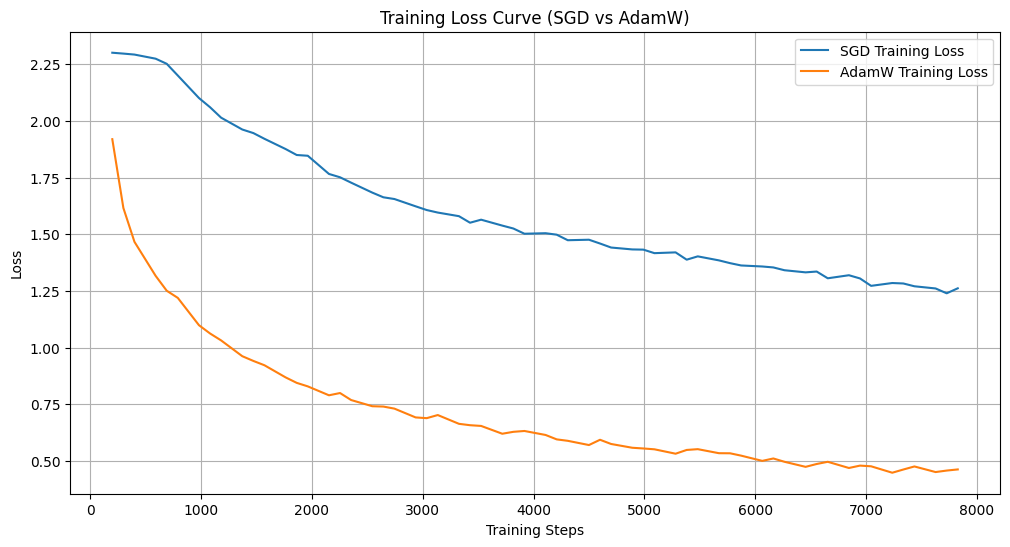

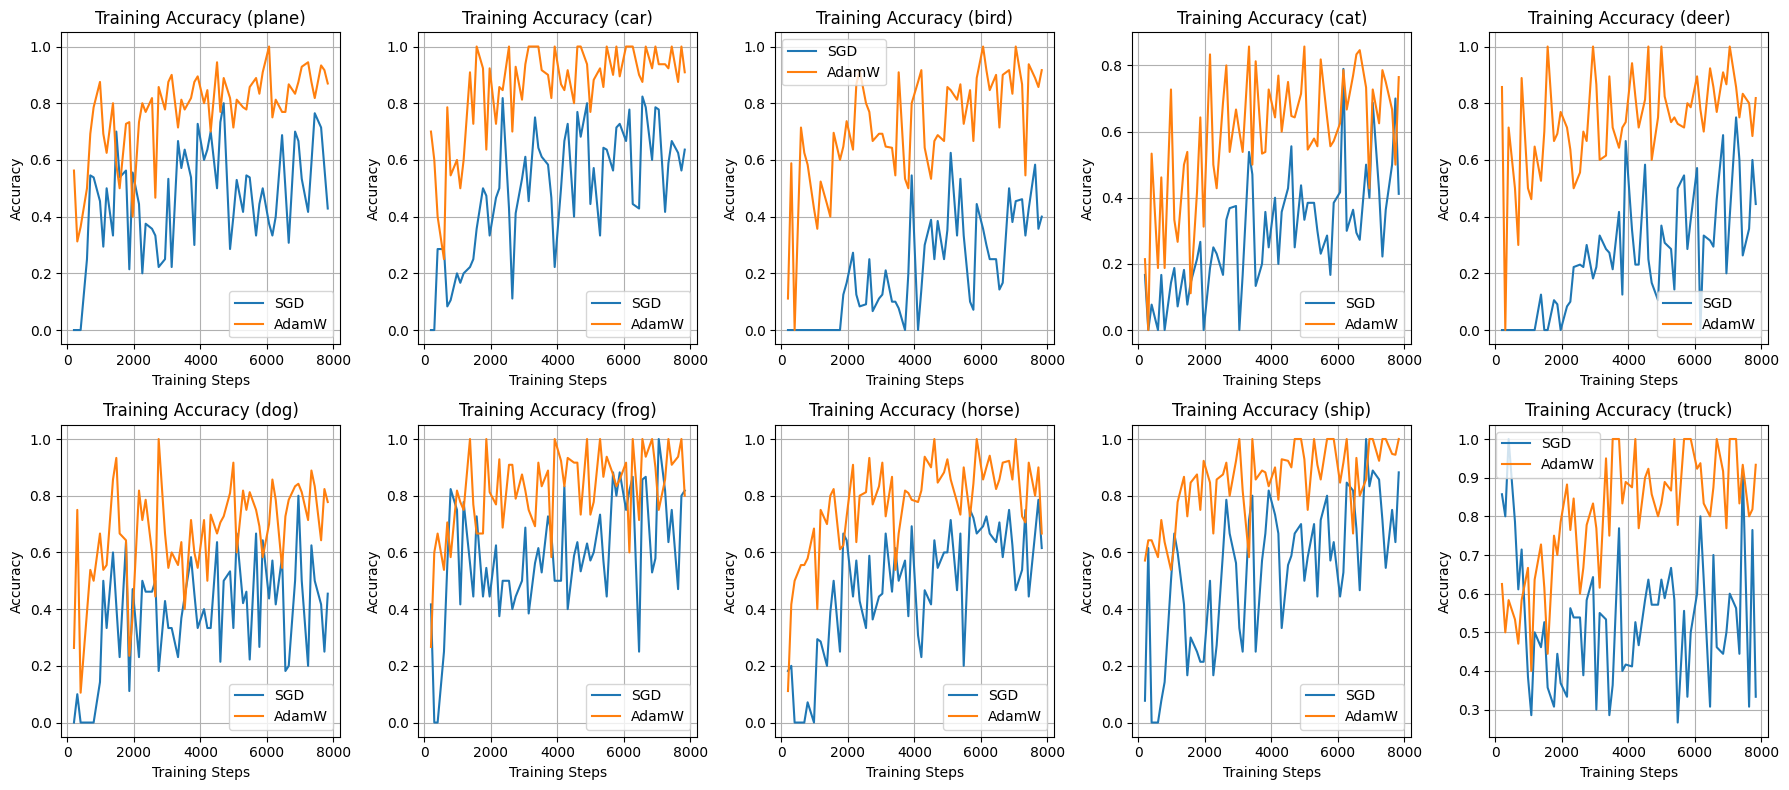

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(sgd_train_steps, sgd_train_losses, label='SGD Training Loss')
plt.plot(adamw_train_steps, adamw_train_losses, label='AdamW Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve (SGD vs AdamW)')
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    num_points_sgd = min(len(sgd_train_steps), len(sgd_accuracies_per_class[class_name]))
    num_points_adamw = min(len(adamw_train_steps), len(adamw_accuracies_per_class[class_name]))

    axes[i].plot(sgd_train_steps[:num_points_sgd], sgd_accuracies_per_class[class_name][:num_points_sgd], label='SGD')
    axes[i].plot(adamw_train_steps[:num_points_adamw], adamw_accuracies_per_class[class_name][:num_points_adamw], label='AdamW')
    axes[i].set_title(f'Training Accuracy ({class_name})')
    axes[i].set_xlabel('Training Steps')
    axes[i].set_ylabel('Accuracy')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()